In [2]:
from typing import Tuple, NamedTuple, Set, Mapping, Sequence
from itertools import chain, product, groupby
import numpy as np
from numpy.core.multiarray import ndarray
from scipy.stats import lognorm
from processes.mdp_refined import MDPRefined
from func_approx.dnn_spec import DNNSpec
from func_approx.func_approx_base import FuncApproxBase
from func_approx_spec import FuncApproxSpec
from copy import deepcopy
from operator import itemgetter
from processes.det_policy import DetPolicy
from dp.dp_analytic import DPAnalytic
from dp.dp_numeric import DPNumeric
import json
import os
import FigureFunc
from adp.adp import ADP

StateType = Tuple[int, ...]
# DP algorithm

class InvEnv(NamedTuple):
    L_max: float
    L_min: float
    mu_inflow: Sequence[float]
    sigma_inflow: Sequence[float]
    mu_price: Sequence[float]
    sigma_price: Sequence[float]
    epoch_disc_factor: float
    failure_cost: float
    condition_ini: float
    av_det: float
    adjust_rate: float
    prod_cap: float
    len_month: int
    gran: float

    def validate_spec(self) -> bool:
        b1 = self.L_max > 0.
        b2 = self.L_min >= 0
        #b3 = self.mu_inflow > 0.
        #b4 = self.sigma_inflow >= 0.
        b5 = 0. <= self.epoch_disc_factor <= 1.
        #b6 = self.mu_price > 0.
        #b7 = self.sigma_price > 0.
        b8 = self.failure_cost > 0.
        return all([b1, b2, b5, b8])

    def get_all_states(self) -> Set[StateType]:
        # reservior level
        on_hand_range = list(np.arange(int(self.L_min), int(self.L_max + 1), self.gran))
        if self.av_det == 0.:
            current_cond = list([0.])
        else:
            current_cond = list(np.arange(self.condition_ini, 1.01, self.av_det))
        month = range(self.len_month)
        return set(product(
            *chain([on_hand_range], [current_cond], [month])
        ))

    # Order of operations in an epoch are:
    # 1) Order Placement (Action)
    # 2) Receipt
    # 3) Throwout Space-Limited-Excess Inventory
    # 4) Demand
    # 5) Adjust (Negative) Inventory to not fall below stockout limit

    # In the following func, the input "state" is represented by
    # the on-hand and on-order right before an order is placed (the very
    # first event in the epoch) and the "state"s in the output are represented
    # by the  on-hand and on-order just before the next order is placed (in the
    # next epoch).  Both the input and output "state"s are arrays of length (L+1).

    def get_next_states_probs_rewards(
            self,
            state: StateType,
            action: int,
            inflow_probs:  Sequence[float],
            price_probs: Sequence[float], 
            model
    ) -> Mapping[StateType, Tuple[float, float]]:
        next_state_arr: ndarray = np.array(state)
        #print("next_state_arr, action", next_state_arr, action)
        # The next line represents state change due to Action and Receipt[1 if next_state_arr[2] < 11 else -11]
        next_state_arr += np.append([-action *self.adjust_rate, self.av_det if action > 0. else 0.],
                                    [1 if next_state_arr[2] < self.len_month-1 else -(self.len_month-1)])
        #next_state_arr += np.append(-action *self.adjust_rate, self.av_det if action > 0 else 0.)

        # The next line represents state change due to demand
        temp_list = []

        for price, prob_pr in price_probs:
            #there is no need to create a cost for the failure since we can ensure that the plant never fails by considering 
            # the initial condition to be less than a threshold
            reward = action * price if next_state_arr[1] < 1. else 0.
            #- (self.failure_cost if next_state_arr[1] > 1. else 0.)  
            
            for inflow, prob_in in inflow_probs:
                #print("inflow : {}, next_state_arr[0] : {}".format(inflow, next_state_arr[0]))
                next_state_arr[0] = min(inflow+next_state_arr[0], self.L_max)
                ns = deepcopy(next_state_arr)
                inv = ns[0]
                cond = ns[1]
                onhand = inv
                ns_tup = tuple(x for x in ns)
                temp_list.append((ns_tup, prob_pr, prob_in, reward))

        ret = {}
        crit = itemgetter(0)
        for s, v in groupby(sorted(temp_list, key=crit), key=crit):
            tl = [(p1, p2, r) for _, p1, p2, r in v]
            sum_p1 = sum(p1/len(inflow_probs) for p1, _, _ in tl)
            
            sum_p2 = sum(p2/len(price_probs) for _, p2, _ in tl)
            #print(s, sum_p2)
            if model == "nominal":
                avg_r = sum((p1/len(inflow_probs) * r 
                            for p1, _, r in tl))/(sum_p1) if sum_p1 != 0. else 0.
                #print("sum of probabilities",sum((p2/len(price_probs) for _, p2, _ in tl))/(sum_p2) if sum_p2 != 0. else 0.)
                #print("action, avg_r", action, avg_r)
                ret[s] = (sum_p2, avg_r)
                
#                 print("state:", s)
#                 print("action: {}, reward : {}".format(action, ret[s][1]))
            elif model == "robust":
                r_list = [r for p1, _, r in tl if p1 != 0]
#                 print(s)
#                 print(action, r_list)
                if r_list:
                    worst_r = min(r_list)
                    worst_r = sum((p1/len(inflow_probs) * worst_r 
                            for p1, _, _ in tl))/(sum_p1) if sum_p1 != 0. else 0.
                    
                else:
                    worst_r = 0.

                ret[s] = (sum_p2, worst_r)
            else:
                raise ValueError("Model is not selected appropriately")
                
        return ret

    def get_mdp_refined_dict(self, model) \
            -> Mapping[StateType,
                       Mapping[int,
                               Mapping[StateType,
                                       Tuple[float, float]]]]:
        ret_price, ret_inflow = self.get_exogenous_state()
        #print("pp_inflow", pp_inflow)
        return {s: {a: self.get_next_states_probs_rewards(s, a, ret_inflow[s[-1]], ret_price[s[-1]], model)
                    for a in np.arange(0, self.get_all_actions(s), self.gran)}
                for s in self.get_all_states()}

    def get_exogenous_state(self):
        # self.mu_price is a list
        rv_price = [0] * self.len_month
        rv_inflow = [0] * self.len_month
        raw_price_probs = [0] * self.len_month
        raw_inflow_probs = [0] * self.len_month
        pp_price = [0] * self.len_month
        pp_inflow = [0] * self.len_month
        ret_inflow = [[] for _ in range(self.len_month)]
        ret_price = [[] for _ in range(self.len_month)]
        for month in range(self.len_month):
            rv_price[month] = lognorm(s= self.sigma_price[month], scale = self.mu_price[month])
            rv_inflow[month] = lognorm(s = self.sigma_inflow[month], scale = self.mu_inflow[month])
            raw_price_probs[month] = [rv_price[month].cdf(i) for i in np.arange(0, int(rv_price[month].ppf(0.95)), self.gran)]
            raw_inflow_probs[month] = [rv_inflow[month].cdf(i) for i in np.arange(0, int(rv_inflow[month].ppf(0.95)), self.gran)]
            pp_price[month] = [p / sum(raw_price_probs[month]) for p in raw_price_probs[month]]
            pp_inflow[month] = [p / sum(raw_inflow_probs[month]) for p in raw_inflow_probs[month]]
            for i, num in enumerate(np.arange(0, int(rv_price[month].ppf(0.95)), self.gran)):
                ret_price[month].append([num, pp_price[month][i]])
            for i, num in enumerate(np.arange(0, int(rv_inflow[month].ppf(0.95)), self.gran)):
                ret_inflow[month].append([num, pp_inflow[month][i]])
            #print(ret_inflow[month])
                
        #print({month: ret_inflow[month] for month in range(self.len_month)})
        return {month: ret_price[month] for month in range(self.len_month)}, {month: ret_inflow[month] for month in range(self.len_month)}
        
            
            

    # Actions given the inventory 
    def get_all_actions(self, state):
        if state[1] >= 1.:
            cap = self.gran
        else:
            cap = max(min(self.prod_cap, (state[0] - self.L_min)* (1/self.adjust_rate)), self.gran)
#             if state[0] > 90:
#                 print("cap", cap)
        return cap
        
        
        
    def get_mdp_refined(self, model) -> MDPRefined:
        return MDPRefined(self.get_mdp_refined_dict(model), self.epoch_disc_factor)

    def get_optimal_policy(self) -> DetPolicy:
        return self.get_mdp_refined().get_optimal_policy()

    def get_ips_orders_dict(self) -> Mapping[int, Sequence[int]]:
        sa_pairs = self.get_optimal_policy().get_state_to_action_map().items()

        def crit(x: Tuple[Tuple[int, ...], int]) -> int:
            return sum(x[0])

        return {ip: [y for _, y in v] for ip, v in
                groupby(sorted(sa_pairs, key=crit), key=crit)}


if __name__ == '__main__':
    import time
    start = time.time()
    #initial parameters
#     kwargs = {"L_max":20., "L_min":1. ,"mu_inflow":[3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 5., 5., 5.]  , "sigma_inflow":[1.] * 12,
#           "mu_price": [2.] * 12,"sigma_price": [0.5] *12, "epoch_disc_factor":0.96, 
#           "failure_cost":10., "condition_ini":0., "av_det": 0.2,"adjust_rate":1,"prod_cap": 5.,
#           "len_month":12}
    # month and reservior level
#     kwargs = {"L_max":20., "L_min":1. ,"mu_inflow":[3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 5., 5., 5.]  , "sigma_inflow":[1.] * 12,
#           "mu_price": [2.] * 12,"sigma_price": [0.5] *12, "epoch_disc_factor":0.96, 
#           "failure_cost":10., "condition_ini":0., "av_det": 0.,"adjust_rate":1,"prod_cap": 5.,
#           "len_month":12}

    # reservior level and condition of plant
    kwargs = {"L_max":100., "L_min":1. ,"mu_inflow":[3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 5., 5., 5.]  , "sigma_inflow":[1.] * 12,
          "mu_price": [2.] * 12,"sigma_price": [0.5] *12, "epoch_disc_factor":0.96, 'gran' : 1.0,
          "failure_cost":10., "condition_ini":0., "av_det": 0.2,"adjust_rate":1,"prod_cap": 5.,
          "len_month":1}



#     resservior level
#     kwargs = {"L_max":100., "L_min":1. ,"mu_inflow":[3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 5., 5., 5.]  , "sigma_inflow":[1.] * 12,
#           "mu_price": [2.] * 12,"sigma_price": [0.5] *12, "epoch_disc_factor":0.96, 
#           "failure_cost":10., "condition_ini":0., "av_det": 0.,"adjust_rate":1,"prod_cap": 5.,
#           "len_month":1}
    
    
    inv = InvEnv(**kwargs)
    States = inv.get_all_states()

    if not inv.validate_spec():
        raise ValueError
        
    mdp_ref_obj1 = inv.get_mdp_refined(model = "nominal")
    mdp_ref_obj = mdp_ref_obj1.get_mdp_rep_for_adp()
    this_tolerance = 1e-3
    exploring_start = False
    this_first_visit_mc = True
    num_samples = 30
    this_softmax = False
    this_epsilon = 0.05
    this_epsilon_half_life = 30
    this_learning_rate = 0.01
    this_learning_rate_decay = 1e6
    this_lambd = 0.8
    this_num_episodes = 3000
    this_batch_size = 10
    this_max_steps = 10
    this_tdl_fa_offline = True
    #state_ffs = FuncApproxBase.get_inv_feature_funcs(range(11), 2)
    state_ffs = FuncApproxBase.get_identity_feature_funcs(2)
    sa_ffs = [(lambda x, f=f: f(x[0])) for f in state_ffs] + [lambda x: x[1]]
    this_fa_spec = FuncApproxSpec(
        state_feature_funcs=state_ffs,
        sa_feature_funcs=sa_ffs,
        dnn_spec = DNNSpec(
            neurons=[2, 4],
            hidden_activation=DNNSpec.relu,
            hidden_activation_deriv=DNNSpec.relu_deriv,
            output_activation=DNNSpec.identity,
            output_activation_deriv=DNNSpec.identity_deriv
        )
    )

    adp_obj = ADP(
    mdp_rep_for_adp=mdp_ref_obj,
    num_samples=num_samples,
    softmax=this_softmax,
    epsilon=this_epsilon,
    epsilon_half_life=this_epsilon_half_life,
    tol=this_tolerance,
    fa_spec=this_fa_spec
    ) 
    def criter(x: Tuple[Tuple[int, ...], int]) -> int:
        return sum(x[0])
    experiment_path = "Results/"
    if not os.path.exists(experiment_path):
        os.makedirs(experiment_path)
    if not os.path.exists(experiment_path + "/ADP/"):
        os.makedirs(experiment_path + "/ADP/")
    config_path = experiment_path + "/ADP/config.json"
    with open(config_path, "w") as f:
        json.dump(kwargs, f)

    opt_det_policy, opt_value_fa, parameters = adp_obj.get_optimal_policy_func_vi()
    #opt_det_policy_robust, opt_value_fa_robust, parameters_robust = adp_obj.get_optimal_policy_Robust_func_vi()
    print(parameters)
#     for s in States:
#         print("States: {}, Optimal value function: {}\n".format(s, opt_value_fa(s)))
#     results = experiment_path + "/ADP/VF_Pol.txt"
#     output= open(results, 'wt')
#     for s in States:
#         output.write("States: {}, Optimal value function: {}\n".format(s, opt_value_fa(s)))
#     #output.write("#################Policy###########################")
#     #output.write("Policy: {}\n".format(opt_det_policy))
#     end = time.time()
#     execution_time = end - start
#     output.write("Execution time: {}".format(execution_time))
#     output.close()

sa_feature_funcs [<function <listcomp>.<lambda> at 0x7fec906cdd90>, <function <listcomp>.<lambda> at 0x7fec906cdbf8>, <function <lambda> at 0x7fec906cdd08>]
test: 3
self.params [array([[ 0.3108422 ,  0.06723824,  0.31290362],
       [ 0.16361269,  0.32794414,  0.44297663]]), array([[ 0.38058382,  0.03181902,  0.46417372],
       [ 0.16345109,  0.06697427,  0.27562251],
       [ 0.3164199 ,  0.55223745,  0.29099256],
       [ 0.56969316,  0.10806315,  0.39982875]]), array([[ 0.42385281,  0.65521929, -0.30045145, -0.37916497,  0.34621732]])]
0.96
[array([[ -6.84432438e-01,  -9.70467655e-01,  -6.62227968e-01],
       [  1.13971200e+03,   1.14204809e+03,   1.12798854e+03]]), array([[  1.11883723e+03,   1.08255309e+00,   1.14251776e+03],
       [ -1.65774155e+00,  -9.82395093e-01,  -1.56556528e+00],
       [ -1.55279426e+00,  -4.97326446e-01,  -1.56077205e+00],
       [  1.11901945e+03,   1.15917904e+00,   1.14244525e+03]]), array([[ 1095.99856856,  1142.7058695 ,     1.48590159,     1.4623

In [4]:
for s in States:
    print(s, opt_value_fa(s))

(51.0, 0.40000000000000002, 0) 156214363761.0
(43.0, 1.0, 0) 134128960081.0
(98.0, 1.0, 0) 298113545356.0
(90.0, 0.40000000000000002, 0) 272494342410.0
(36.0, 0.0, 0) 110313361960.0
(75.0, 0.80000000000000004, 0) 228949206787.0
(21.0, 0.40000000000000002, 0) 66768226337.6
(45.0, 0.60000000000000009, 0) 138914102820.0
(10.0, 0.20000000000000001, 0) 33382342738.3
(69.0, 0.40000000000000002, 0) 209882046214.0
(61.0, 1.0, 0) 187796642534.0
(15.0, 0.80000000000000004, 0) 50056931941.7
(54.0, 0.0, 0) 163981044414.0
(93.0, 0.80000000000000004, 0) 282616889241.0
(39.0, 0.40000000000000002, 0) 120435908791.0
(4.0, 0.20000000000000001, 0) 15493115253.7
(97.0, 0.20000000000000001, 0) 292776141265.0
(63.0, 0.60000000000000009, 0) 192581785274.0
(79.0, 1.0, 0) 241464324988.0
(17.0, 0.80000000000000004, 0) 56020007769.9
(56.0, 0.0, 0) 169944120242.0
(2.0, 0.40000000000000002, 0) 10119005969.8
(100.0, 0.20000000000000001, 0) 301720755007.0
(65.0, 0.60000000000000009, 0) 198544861102.0
(81.0, 1.0, 0) 

(38.0, 1.0, 0) 119221270510.0
(30.0, 0.40000000000000002, 0) 93602067564.5
(54.0, 0.60000000000000009, 0) 165747944047.0
(8.0, 0.80000000000000004, 0) 29186166543.0
(63.0, 0.0, 0) 190814885641.0
(40.0, 1.0, 0) 125184346338.0
(91.0, 0.20000000000000001, 0) 274886913780.0
(56.0, 0.60000000000000009, 0) 171711019875.0
(26.0, 0.80000000000000004, 0) 82853848996.8
(65.0, 0.0, 0) 196777961469.0
(46.0, 0.20000000000000001, 0) 140717707646.0
(3.0, 1.0, 0) 14867443516.9
(58.0, 1.0, 0) 178852028792.0
(74.0, 0.60000000000000009, 0) 225378702329.0
(5.0, 0.60000000000000009, 0) 19652586256.4
(44.0, 0.80000000000000004, 0) 136521531450.0
(83.0, 0.0, 0) 250445643923.0
(48.0, 0.20000000000000001, 0) 146680783474.0
(21.0, 1.0, 0) 68535125970.6
(76.0, 1.0, 0) 232519711246.0
(33.0, 0.20000000000000001, 0) 101957714762.0
(14.0, 0.0, 0) 44719527850.4
(53.0, 0.80000000000000004, 0) 163355372677.0
(92.0, 0.60000000000000009, 0) 279046384783.0
(23.0, 0.60000000000000009, 0) 73320268710.2
(39.0, 1.0, 0) 122202

In [14]:
import matplotlib
import matplotlib.pyplot as plt
month = []
res_level = []


# parameters: [array([ 0.09999475,  0.09999931,  0.,  0.099999])]
Data = {(s[0], s[2]): opt_value_fa(s) for s in States}
for key in Data.keys():
    res_level.append(key[0])
    month.append(key[1])
res_level = sorted(set(res_level))
month = sorted(set(month))
values = np.zeros((len(res_level), len(month)))
for i, elem1 in enumerate(res_level):
    for j, elem2 in enumerate(month):
        values[i, j] = opt_value_fa((elem1, 0., elem2))
#res_level and month
fig, ax = plt.subplots()
im, cbar = FigureFunc.heatmap(values.T, month, res_level, ax=ax,  cmap="YlGn", cbarlabel="Approximate Value Iteration")
ax.set_ylabel("Month")
ax.set_xlabel("reservior level")
fig.tight_layout()
plt.show()        



TypeError: heatmap() missing 1 required positional argument: 'cbar_kw'

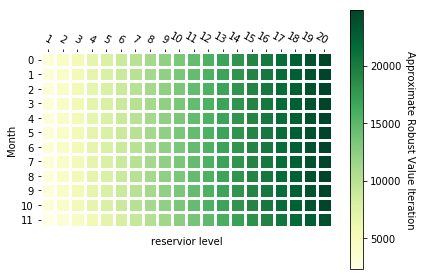

In [6]:
import matplotlib
import matplotlib.pyplot as plt
month = []
res_level = []


# parameters: [array([ 0.09999475,  0.09999931,  0.,  0.099999])]
Data = {(s[0], s[2]): opt_value_fa_robust(s) for s in States}
for key in Data.keys():
    res_level.append(key[0])
    month.append(key[1])
res_level = sorted(set(res_level))
month = sorted(set(month))
values = np.zeros((len(res_level), len(month)))
for i, elem1 in enumerate(res_level):
    for j, elem2 in enumerate(month):
        values[i, j] = opt_value_fa_robust((elem1, 0., elem2))
#res_level and month
fig, ax = plt.subplots()
im, cbar = heatmap(values.T,  month, res_level, ax=ax,  cmap="YlGn", cbarlabel="Approximate Robust Value Iteration")
ax.set_ylabel("Month")
ax.set_xlabel("reservior level")
fig.tight_layout()
plt.show()    

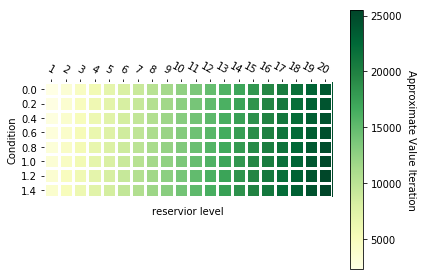

In [12]:
import matplotlib
import matplotlib.pyplot as plt
condition = []
res_level = []

Data = {(s[0], s[1]): opt_value_fa(s) for s in States}
for key in Data.keys():
    res_level.append(key[0])
    condition.append(key[1])
res_level = sorted(set(res_level))
condition = sorted(set(condition))
values = np.zeros((len(res_level), len(condition)))
for i, elem1 in enumerate(res_level):
    for j, elem2 in enumerate(condition):
        values[i, j] = opt_value_fa((elem1, elem2, 0.))
#res_level and month
fig, ax = plt.subplots()
im, cbar = heatmap(values.T, condition, res_level, ax=ax,  cmap="YlGn", cbarlabel="Approximate Value Iteration")
ax.set_ylabel("Condition")
ax.set_xlabel("reservior level")
fig.tight_layout()
plt.show()        


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
condition = []
res_level = []

Data = {(s[0], s[1]): opt_value_fa_robust(s) for s in States}
for key in Data.keys():
    res_level.append(key[0])
    condition.append(key[1])
res_level = sorted(set(res_level))
condition = sorted(set(condition))
values = np.zeros((len(res_level), len(condition)))
for i, elem1 in enumerate(res_level):
    for j, elem2 in enumerate(condition):
        values[i, j] = opt_value_fa_robust((elem1, elem2, 0.))
#res_level and month
fig, ax = plt.subplots()
im, cbar = heatmap(values.T, condition, res_level, ax=ax,  cmap="YlGn", cbarlabel="Approximate Value Iteration")
ax.set_ylabel("Condition")
ax.set_xlabel("reservior level")
fig.tight_layout()
plt.show()        


In [4]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts